In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import random

warnings.filterwarnings('ignore')

In [ ]:
# ===== ENHANCED TOKENIZATION STRATEGIES =====

def adaptive_tokenize(text, tokenizer, max_len=512):
    """
    Adaptive tokenization that preserves important content based on text length
    """
    tokens = tokenizer.encode(text, add_special_tokens=True)

    if len(tokens) <= max_len:
        return tokens

    # Strategy 1: For very long texts, use sliding window approach
    if len(tokens) > max_len * 3:
        # Take beginning, middle, and end chunks
        chunk_size = max_len // 3
        beginning = tokens[:chunk_size]
        middle_start = len(tokens) // 2 - chunk_size // 2
        middle = tokens[middle_start:middle_start + chunk_size]
        end = tokens[-chunk_size:]
        return beginning + middle + end

    # Strategy 2: For moderately long texts, use head-tail with bias toward beginning
    else:
        head_ratio = 0.6  # Give more weight to beginning
        head_len = int(max_len * head_ratio)
        tail_len = max_len - head_len
        head = tokens[:head_len]
        tail = tokens[-tail_len:]
        return head + tail

def enhanced_pre_tokenize(texts, labels, tokenizer, max_len=512):
    """Enhanced tokenization with multiple strategies"""
    input_ids = []
    attention_masks = []

    for text in tqdm(texts, desc="Tokenizing"):
        tokens = adaptive_tokenize(text, tokenizer, max_len)

        # Ensure exact length
        if len(tokens) < max_len:
            tokens = tokens + [tokenizer.pad_token_id] * (max_len - len(tokens))
        else:
            tokens = tokens[:max_len]

        mask = [1 if t != tokenizer.pad_token_id else 0 for t in tokens]
        input_ids.append(tokens)
        attention_masks.append(mask)

    return {
        'input_ids': torch.tensor(input_ids),
        'attention_mask': torch.tensor(attention_masks),
        'labels': torch.tensor(labels)
    }

In [ ]:
class AdvancedFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, weights=None, label_smoothing=0.1, device='cuda'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weights = weights
        self.label_smoothing = label_smoothing
        self.device = device

    def forward(self, inputs, targets):
        targets = targets.to(self.device)

        # Apply label smoothing
        num_classes = inputs.size(1)
        smooth_targets = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
        smooth_targets = smooth_targets * (1 - self.label_smoothing) + self.label_smoothing / num_classes

        # Compute focal loss with smoothed targets
        log_pt = F.log_softmax(inputs, dim=1)
        ce_loss = -(smooth_targets * log_pt).sum(dim=1)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.weights is not None:
            weights = self.weights[targets]
            weighted_loss = focal_loss * weights
            return weighted_loss.mean()
        return focal_loss.mean()


In [ ]:
# ===== ENHANCED DATASET CLASS =====

class EnhancedDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels, tokenizer, augment=False):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
        self.tokenizer = tokenizer
        self.augment = augment
        self.augmentation = TextAugmentation(prob=0.3) if augment else None

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        labels = self.labels[idx]

        # Apply augmentation during training
        if self.augment and self.augmentation:
            input_ids = self.augmentation.random_mask(input_ids, self.tokenizer)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }



In [ ]:
# ===== IMPROVED OPTIMIZER WITH LAYER-WISE LEARNING RATES =====

def get_enhanced_optimizer_params(model, base_lr=2e-5, lr_decay=0.9, weight_decay=0.01):
    """Enhanced optimizer with better layer-wise learning rates"""
    no_decay = ["bias", "LayerNorm.weight", "layernorm.weight"]
    optimizer_grouped_parameters = []

    # Classifier head - highest learning rate
    optimizer_grouped_parameters.extend([
        {
            "params": [p for n, p in model.named_parameters() if "classifier" in n and not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
            "lr": base_lr * 2,  # Higher LR for classifier
        },
        {
            "params": [p for n, p in model.named_parameters() if "classifier" in n and any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
            "lr": base_lr * 2,
        }
    ])

    # RoBERTa layers (12 layers: 0-11, higher layers get higher LR)
    for i in range(11, -1, -1):
        lr_multiplier = lr_decay ** (11 - i)
        layer_lr = base_lr * lr_multiplier

        optimizer_grouped_parameters.extend([
            {
                "params": [p for n, p in model.named_parameters() if f"layer.{i}." in n and not any(nd in n for nd in no_decay)],
                "weight_decay": weight_decay,
                "lr": layer_lr,
            },
            {
                "params": [p for n, p in model.named_parameters() if f"layer.{i}." in n and any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": layer_lr,
            }
        ])

    # Embeddings - lowest learning rate
    optimizer_grouped_parameters.extend([
        {
            "params": [p for n, p in model.named_parameters() if "embeddings" in n and not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
            "lr": base_lr * (lr_decay ** 12),
        },
        {
            "params": [p for n, p in model.named_parameters() if "embeddings" in n and any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
            "lr": base_lr * (lr_decay ** 12),
        }
    ])

    return optimizer_grouped_parameters




In [ ]:
# ===== ENHANCED TRAINER WITH BETTER UNFREEZING STRATEGY =====

class EnhancedTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn
        self.label_names = ["labels"]
        self.current_epoch = 0
        self.best_f1 = 0.0

    def create_optimizer(self):
        if self.optimizer is None:
            optimizer_grouped_parameters = get_enhanced_optimizer_params(
                self.model, base_lr=self.args.learning_rate, lr_decay=0.9
            )
            self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, eps=1e-8)
        return self.optimizer


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

    def progressive_unfreezing(self, epoch):
        """Progressive unfreezing strategy"""
        if epoch == 0:
            # Freeze all except classifier and last 2 layers
            for name, param in self.model.named_parameters():
                if not any(x in name for x in ['classifier', 'layer.10', 'layer.11']):
                    param.requires_grad = False

        elif epoch == 1:
            # Unfreeze last 4 layers
            for name, param in self.model.named_parameters():
                if any(x in name for x in ['classifier', 'layer.8', 'layer.9', 'layer.10', 'layer.11']):
                    param.requires_grad = True

        elif epoch == 2:
            # Unfreeze last 6 layers
            for name, param in self.model.named_parameters():
                if any(x in name for x in ['classifier', 'layer.6', 'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11']):
                    param.requires_grad = True

        else:
            # Unfreeze all layers
            for param in self.model.parameters():
                param.requires_grad = True

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.progressive_unfreezing(state.epoch)
        return super().on_epoch_begin(args, state, control, **kwargs)

In [ ]:
# ===== ENHANCED EVALUATION METRICS =====

def compute_enhanced_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'precision_weighted': precision_score(labels, predictions, average='weighted'),
        'recall_weighted': recall_score(labels, predictions, average='weighted'),
        'precision_macro': precision_score(labels, predictions, average='macro'),
        'recall_macro': recall_score(labels, predictions, average='macro')
    }

In [ ]:
# ===== MAIN TRAINING SETUP =====

# Load and prepare data
data = pd.read_csv("/content/drive/MyDrive/combined_data.csv")
ndata = data.dropna().reset_index(drop=True)

text = ndata['text']
labels = ndata['mental_state'].values
label_map = {emotion: idx for idx, emotion in enumerate(np.unique(labels))}
num_labels = len(label_map)
y_encoded = np.array([label_map[l] for l in labels])

# Initialize model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels).to(device)

# Enhanced data split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    text, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Initialize enhanced loss function
loss_fn = AdvancedFocalLoss(
    alpha=0.25, gamma=2.5, weights=weights_tensor,
    label_smoothing=0.1, device=device
)

In [ ]:
# Enhanced tokenization
MAX_LEN = 512
train_data = enhanced_pre_tokenize(X_train.tolist(), y_train, tokenizer, MAX_LEN)
val_data = enhanced_pre_tokenize(X_val.tolist(), y_val, tokenizer, MAX_LEN)


In [ ]:
# Create enhanced datasets
train_dataset = EnhancedDataset(
    train_data['input_ids'], train_data['attention_mask'],
    train_data['labels'], tokenizer, augment=False
)
val_dataset = EnhancedDataset(
    val_data['input_ids'], val_data['attention_mask'],
    val_data['labels'], tokenizer, augment=False
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Enhanced training arguments
training_args = TrainingArguments(
    output_dir='./enhanced_results',
    num_train_epochs=6,  # Increased epochs for better learning
    per_device_train_batch_size=8,  # Smaller batch size for stability
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,  # Effective batch size = 16
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    fp16=torch.cuda.is_available(),
    logging_dir='./logs',
    logging_steps=100,
    report_to='none',
    dataloader_pin_memory=True,
    ddp_find_unused_parameters=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True,
    save_total_limit=3,
    eval_accumulation_steps=1,
    adam_epsilon=1e-8,
    max_grad_norm=1.0,
    dataloader_num_workers=2,
)

# Initialize enhanced trainer
trainer = EnhancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_enhanced_metrics,
    loss_fn=loss_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)



# Train the model
print("Starting enhanced training...")
trainer.train()

# Evaluate
results = trainer.evaluate()
print("Enhanced Validation Results:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

# Save enhanced model
save_path = "/content/drive/MyDrive/enhanced_bert_results_will_it_work"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"Enhanced model saved to: {save_path}")

Starting enhanced training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Precision Weighted,Recall Weighted,Precision Macro,Recall Macro
1,0.126300,0.132636,0.768753,0.771339,0.727997,0.780640,0.768753,0.713847,0.756765
2,0.100000,0.126044,0.762749,0.764981,0.721289,0.784080,0.762749,0.696769,0.774514
3,0.081100,0.128279,0.771593,0.772109,0.741259,0.789233,0.771593,0.719303,0.776153
4,0.078900,0.142604,0.757840,0.756719,0.749477,0.795649,0.757840,0.741313,0.775236
5,0.048300,0.146835,0.783683,0.784599,0.755776,0.797464,0.783683,0.738223,0.782326
6,0.061600,0.153210,0.789647,0.790531,0.759475,0.797461,0.789647,0.748973,0.773300


Enhanced Validation Results:
eval_loss: 0.1532
eval_accuracy: 0.7896
eval_f1_weighted: 0.7905
eval_f1_macro: 0.7595
eval_precision_weighted: 0.7975
eval_recall_weighted: 0.7896
eval_precision_macro: 0.7490
eval_recall_macro: 0.7733
eval_runtime: 186.9051
eval_samples_per_second: 131.8800
eval_steps_per_second: 8.2450
epoch: 6.0000
Enhanced model saved to: /content/drive/MyDrive/enhanced_bert_results_will_it_work


In [6]:
# Load and prepare data
data = pd.read_csv("/content/drive/MyDrive/combined_data.csv")
ndata = data.dropna().reset_index(drop=True)

text = ndata['text']
labels = ndata['mental_state'].values
label_map = {emotion: idx for idx, emotion in enumerate(np.unique(labels))}
num_labels = len(label_map)
y_encoded = np.array([label_map[l] for l in labels])

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/enhanced_bert_results_will_it_work"

tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaModel.from_pretrained(model_path).to(device)

In [ ]:
def get_embeddings_mean_max_chunked(texts, tokenizer, model, device, max_length=512, stride=256):
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    if isinstance(texts, str):
        texts = [texts]
    all_embeddings = []
    hidden_size = getattr(model.config, "dim", None) or getattr(model.config, "hidden_size", 768)
    for text in texts:
        # Use tokenizer's built-in chunking
        inputs = tokenizer(
            text,
            return_tensors="pt",
            max_length=max_length,
            truncation=True,
            padding="max_length",
            stride=stride,
            return_overflowing_tokens=True
        )
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        chunk_embeddings = []
        for i in range(input_ids.size(0)):
            with torch.no_grad():
                outputs = model(input_ids=input_ids[i:i+1], attention_mask=attention_mask[i:i+1])
            last_hidden = outputs.last_hidden_state
            mask = attention_mask[i:i+1].unsqueeze(-1).expand(last_hidden.size()).float()
            mean_pool = torch.sum(last_hidden * mask, 1) / torch.clamp(mask.sum(1), min=1e-9)
            max_pool = torch.max(last_hidden.masked_fill(mask == 0, -1e9), 1)[0]
            pooled = torch.cat([mean_pool, max_pool], dim=1)
            chunk_embeddings.append(pooled.cpu().numpy())
        if chunk_embeddings:
            all_embeddings.append(np.mean(np.vstack(chunk_embeddings), axis=0))
        else:
            all_embeddings.append(np.zeros((hidden_size * 2,)))
    return np.vstack(all_embeddings)

embeddings = get_embeddings_mean_max_chunked(text, tokenizer, model, device)
np.save('/content/drive/MyDrive/roberta_embeddings_yess_2025.npy', embeddings)
pd.DataFrame(embeddings).to_csv('/content/drive/MyDrive/roberta_embeddings_yess_2025.csv', index=False)

In [3]:
embeddings = np.load('/content/drive/MyDrive/roberta_embeddings_yess_2025.npy')


Starting Cross-Validation...

==================== Fold 1 / 5 ====================
[0]	train-mlogloss:2.15935	train-merror:0.13849	val-mlogloss:2.16016	val-merror:0.16786
[100]	train-mlogloss:0.35698	train-merror:0.08590	val-mlogloss:0.44063	val-merror:0.12435
[200]	train-mlogloss:0.22532	train-merror:0.08054	val-mlogloss:0.33015	val-merror:0.12288
[300]	train-mlogloss:0.19615	train-merror:0.07386	val-mlogloss:0.31625	val-merror:0.12191
[373]	train-mlogloss:0.18279	train-merror:0.06888	val-mlogloss:0.31307	val-merror:0.12272
Fold 1 - Accuracy: 0.8781, F1: 0.8786, Loss: 0.3183

==================== Fold 2 / 5 ====================
[0]	train-mlogloss:2.15936	train-merror:0.13533	val-mlogloss:2.16014	val-merror:0.16187
[100]	train-mlogloss:0.35709	train-merror:0.08672	val-mlogloss:0.44053	val-merror:0.12379
[200]	train-mlogloss:0.22567	train-merror:0.08074	val-mlogloss:0.32807	val-merror:0.12364
[228]	train-mlogloss:0.21494	train-merror:0.07878	val-mlogloss:0.32132	val-merror:0.12308
Fold 

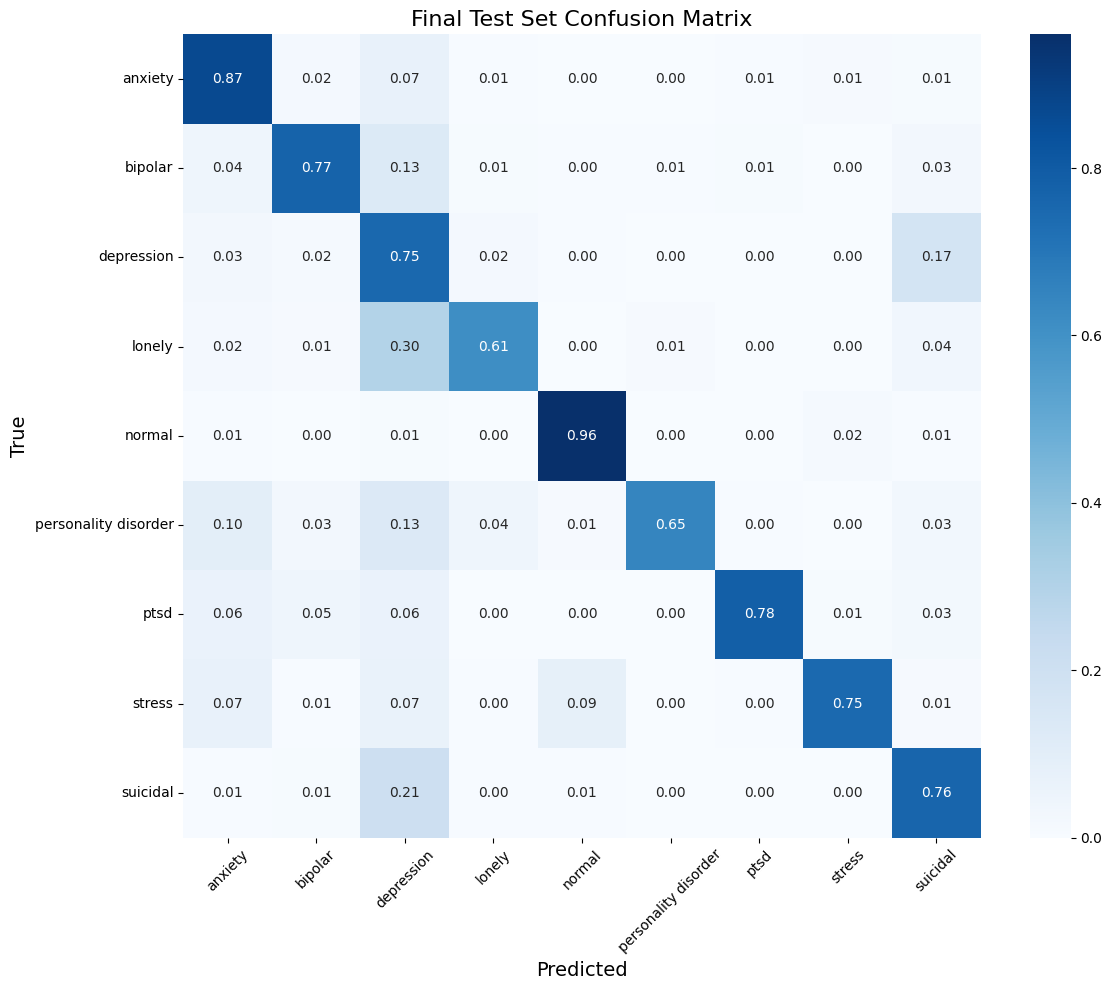


Top 20 Most Important Features:
 1. f466: 4345.2671
 2. f200: 4137.8740
 3. f721: 3778.3945
 4. f22: 3601.8728
 5. f289: 2844.9441
 6. f605: 2804.8887
 7. f354: 2622.7654
 8. f88: 2174.1602
 9. f369: 2163.0376
10. f1464: 2152.1030
11. f1489: 2085.9360
12. f1291: 1528.0637
13. f374: 1499.5188
14. f673: 1399.4921
15. f362: 1306.1963
16. f651: 1120.0819
17. f576: 1056.7582
18. f312: 554.0113
19. f1212: 546.8898
20. f1479: 541.9861

Model saved to /content/drive/MyDrive/models/corrected_xgboost_model.model
Scaler saved to /content/drive/MyDrive/models/corrected_scaler.joblib
Label encoder saved to /content/drive/MyDrive/models/corrected_label_encoder.joblib
TF-IDF vectorizer saved to /content/drive/MyDrive/models/corrected_tfidf.joblib

Class Distribution Analysis:
Training set:
anxiety             : 13643 (13.8%)
bipolar             :  6212 (6.3%)
depression          : 39166 (39.7%)
lonely              :  2256 (2.3%)
normal              : 13074 (13.3%)
personality disorder:   862 (0.9%)


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(ndata['mental_state'])

# FIRST: Split the data into train and test sets
X_train_indices, X_test_indices, y_train_final, y_test_final = train_test_split(
    range(len(text)), labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

# Split text and embeddings
text_train = [text.iloc[i] for i in X_train_indices]
text_test = [text.iloc[i] for i in X_test_indices]
embeddings_train = embeddings[X_train_indices]
embeddings_test = embeddings[X_test_indices]

# Fit TF-IDF ONLY on training data
tfidf = TfidfVectorizer(max_features=300)
tfidf_features_train = tfidf.fit_transform(text_train).toarray()
tfidf_features_test = tfidf.transform(text_test).toarray()

# Combine features for training and test sets
X_train_full = np.hstack([embeddings_train, tfidf_features_train])
X_test_full = np.hstack([embeddings_test, tfidf_features_test])

# Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Enhanced XGBoost parameters for imbalanced data
params_xgb = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train_final)),
    'eval_metric': ['mlogloss', 'merror'],
    'learning_rate': 0.03,  # Lower learning rate for better generalization
    'max_depth': 6,         # Reduced depth to prevent overfitting
    'min_child_weight': 30, # Increased for better regularization
    'alpha': 1.0,           # Increased L1 regularization
    'lambda': 1.0,          # Increased L2 regularization
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'seed': 42,
    'tree_method': 'gpu_hist',
    'verbosity': 0,
    'gamma': 0.1,           # Minimum loss reduction for split
    'max_delta_step': 1     # Helps with class imbalance
}

# Cross-validation with proper data splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_metrics = []

print("Starting Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train_final)):
    print(f"\n{'='*20} Fold {fold+1} / {n_splits} {'='*20}")

    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train_final[train_idx], y_train_final[val_idx]

    # Enhanced class weight computation
    class_counts = np.bincount(y_fold_train)
    total = sum(class_counts)
    # Use square root of inverse frequency for less aggressive weighting
    class_weights = [np.sqrt(total / (len(class_counts) * count)) for count in class_counts]
    weights = np.array([class_weights[x] for x in y_fold_train])

    # Create DMatrices
    dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train, weight=weights)
    dval = xgb.DMatrix(X_fold_val, label=y_fold_val)

    # Training with early stopping
    evals_result = {}
    model = xgb.train(
        params_xgb,
        dtrain,
        num_boost_round=2000,  # Increased iterations
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=100,  # More patience
        evals_result=evals_result,
        verbose_eval=100
    )

    # Predictions
    y_pred_proba = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Metrics
    accuracy = accuracy_score(y_fold_val, y_pred)
    precision = precision_score(y_fold_val, y_pred, average='weighted')
    recall = recall_score(y_fold_val, y_pred, average='weighted')
    f1 = f1_score(y_fold_val, y_pred, average='weighted')
    val_loss = log_loss(y_fold_val, y_pred_proba)

    print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Loss: {val_loss:.4f}")

    fold_metrics.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'loss': val_loss
    })

# Print average metrics across folds
print("\n" + "="*50)
print("Cross-Validation Results (Training Data Only):")
print("="*50)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'loss']:
    values = [fm[metric] for fm in fold_metrics]
    print(f"{metric.capitalize():<10}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Train final model on full training set
print("\n" + "="*50)
print("Training Final Model on Full Training Set")
print("="*50)

# Enhanced class weights for final model
class_counts = np.bincount(y_train_final)
total = sum(class_counts)
class_weights = [np.sqrt(total / (len(class_counts) * count)) for count in class_counts]
weights = np.array([class_weights[x] for x in y_train_final])

# Create DMatrices
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_final, weight=weights)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_final)

# Training with early stopping
evals_result = {}
final_model = xgb.train(
    params_xgb,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

# Predictions on test set
y_test_pred_proba = final_model.predict(dtest)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Test metrics
test_accuracy = accuracy_score(y_test_final, y_test_pred)
test_precision = precision_score(y_test_final, y_test_pred, average='weighted')
test_recall = recall_score(y_test_final, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_final, y_test_pred, average='weighted')
test_loss = log_loss(y_test_final, y_test_pred_proba)

print("\n" + "="*50)
print("Final Test Set Performance")
print("="*50)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"Log Loss: {test_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_final, y_test_pred, target_names=le.classes_, digits=4))

# Confusion matrix
cm_test = confusion_matrix(y_test_final, y_test_pred, normalize='true')
plt.figure(figsize=(12,10))
sns.heatmap(cm_test, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Final Test Set Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Feature importance analysis
feature_importance = final_model.get_score(importance_type='gain')
print("\nTop 20 Most Important Features:")
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sorted_features[:20]):
    print(f"{i+1:2d}. {feature}: {importance:.4f}")

# Save models and preprocessors
save_dir = '/content/drive/MyDrive/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save model
model_file = os.path.join(save_dir, 'corrected_xgboost_model.model')
final_model.save_model(model_file)
print(f"\nModel saved to {model_file}")

# Save preprocessors
scaler_file = os.path.join(save_dir, 'corrected_scaler.joblib')
joblib.dump(scaler, scaler_file)
print(f"Scaler saved to {scaler_file}")

encoder_file = os.path.join(save_dir, 'corrected_label_encoder.joblib')
joblib.dump(le, encoder_file)
print(f"Label encoder saved to {encoder_file}")

tfidf_file = os.path.join(save_dir, 'corrected_tfidf.joblib')
joblib.dump(tfidf, tfidf_file)
print(f"TF-IDF vectorizer saved to {tfidf_file}")

# Save class distribution analysis
print("\n" + "="*50)
print("Class Distribution Analysis:")
print("="*50)
print("Training set:")
train_dist = np.bincount(y_train_final)
for i, count in enumerate(train_dist):
    print(f"{le.classes_[i]:<20}: {count:5d} ({count/len(y_train_final)*100:.1f}%)")

print("\nTest set:")
test_dist = np.bincount(y_test_final)
for i, count in enumerate(test_dist):
    print(f"{le.classes_[i]:<20}: {count:5d} ({count/len(y_test_final)*100:.1f}%)")

print("\nClass weights used:")
for i, weight in enumerate(class_weights):
    print(f"{le.classes_[i]:<20}: {weight:.4f}")